In [ ]:
import os
from glob import glob

import numpy as np
import jax.numpy as jnp

import xarray as xr

# import xesmf as xe
import pandas as pd
import dask
import zarr

from utils.param_names import param_names
from utils.initial_params import constants
from utils.subsets import subsets
from utils.global_paths import (
    project_data_path,
    project_code_path,
    loca_path,
    log_path,
)
from utils.constants import (
    location_coords,
    location_names,
    obs_names,
    obs_names_plot,
    obs_colors,
)
from read_inputs import read_projection_inputs
from prediction import make_prediction_vmap
from data_processing import _subset_states

In [ ]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="10GiB",
    walltime="01:00:00",
)
cluster.scale(jobs=30)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.8.46:43515,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Preliminaries

In [ ]:
##############
### Models ###
##############

models = os.listdir(f"{loca_path}/")
models.remove("training_data")
models.remove("scripts")

loca_all = {}

# Loop through models
for model in models:
    loca_all[model] = {}
    # Loop through members
    members = os.listdir(f"{loca_path}/{model}/0p0625deg/")
    for member in members:
        # Append SSPs
        ssps = os.listdir(f"{loca_path}/{model}/0p0625deg/{member}/")
        loca_all[model][member] = ssps

# Matches website (https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/) as of Jan 2023
print(f"# models: {len(models)}")
print(
    f"# model/expts: {np.sum([len(np.unique([item for row in [loca_all[model][member] for member in loca_all[model].keys()] for item in row])) for model in models])}"
)
print(
    f"# model/expts/ens: {np.sum([len(loca_all[model][ssp]) for model in models for ssp in loca_all[model]])}"
)
print(
    f"# model/expts/ens (not including historical): {np.sum([len([ssp for ssp in loca_all[model][member] if ssp != 'historical']) for model in models for member in loca_all[model]])}"
)

# models: 27
# model/expts: 99
# model/expts/ens: 329
# model/expts/ens (not including historical): 221


## Regridding

In [ ]:
###################
# Regrid function
###################
def regrid_subset(model, member, ssp, subset_name, list_of_states):
    # Read inputs
    tasmin_in = xr.open_mfdataset(
        f"{loca_path}/{model}/0p0625deg/{member}/{ssp}/tasmin/*.nc",
        chunks="auto",
    )
    tasmin_in["tasmin"] = tasmin_in["tasmin"] - 273.15
    tasmin_in["tasmin"].attrs["units"] = "degC"

    tasmax_in = xr.open_mfdataset(
        f"{loca_path}/{model}/0p0625deg/{member}/{ssp}/tasmax/*.nc",
        chunks="auto",
    )
    tasmax_in["tasmax"] = tasmax_in["tasmax"] - 273.15
    tasmax_in["tasmax"].attrs["units"] = "degC"

    tas_in = (tasmin_in["tasmin"] + tasmax_in["tasmax"]) / 2.0
    tas_in.attrs["units"] = "degC"

    pr_in = xr.open_mfdataset(
        f"{loca_path}/{model}/0p0625deg/{member}/{ssp}/pr/*.nc", chunks="auto"
    )
    pr_in["pr"] = pr_in["pr"] * 86400
    pr_in["pr"].attrs["units"] = "mm/day"

    # Merge
    ds_in = xr.merge([xr.Dataset({"tas": tas_in}), pr_in])

    # Construct out grid
    nldas_lats = np.load(
        f"{project_code_path}/code/utils/grids/{subset_name}_lat.npy"
    )
    nldas_lons = np.load(
        f"{project_code_path}/code/utils/grids/{subset_name}_lon.npy"
    )

    dr_out = xr.Dataset(
        {
            "lat": (
                ["lat"],
                nldas_lats,
                {"standard_name": "latitude", "units": "degrees_north"},
            ),
            "lon": (
                ["lon"],
                nldas_lons,
                {"standard_name": "longitude", "units": "degrees_east"},
            ),
        }
    )

    # Regrid conservatively
    regridder = xe.Regridder(ds_in, dr_out, "conservative")
    ds_out = regridder(
        ds_in, skipna=True, na_thres=0.99
    )  # This threshold is somewhat subjective

    # Subset to states
    ds_out = _subset_states(ds_out, list_of_states)

    # Store
    ds_out = ds_out.chunk({"time": 200, "lat": -1, "lon": -1})
    compressor = zarr.Blosc(cname="zstd", clevel=3)
    encoding = {
        vname: {"compressor": compressor} for vname in ds_out.data_vars
    }
    ds_out.to_zarr(
        f"{project_data_path}/projections/{subset_name}/forcing/LOCA2/{model}_{member}_{ssp}.zarr",
        encoding=encoding,
        mode="w-",
        consolidated=True,
    )

In [ ]:
## File path function
def make_loca_file_path(loca_path, model, member, ssp, var):
    """
    Returns list of file paths for a given downscaled LOCA output.
    """
    out_path = f"{loca_path}/{model}/0p0625deg/{member}/{ssp}/{var}"

    if os.path.isdir(out_path):
        files = os.listdir(out_path)
        files = [
            file for file in files if file[-7:] != "ORIG.nc"
        ]  # Skip ORIGs (had to fix tasmin naming errors)
        return files
    else:
        return []

### eCONUS

In [6]:
subset_name = "eCONUS"
list_of_states = subsets[subset_name]

In [ ]:
%%time
# Loop through models
for model in models:
    # Loop through members
    for member in loca_all[model].keys():
        # Loop through SSPs
        for ssp in loca_all[model][member]:
            if ssp == "historical":
                continue
            # Some vars are missing for some outputs: skip
            file_paths = make_loca_file_path(
                loca_path, model, member, ssp, "tasmin"
            )
            if len(file_paths) == 0:
                print(f"Missing: {model} {ssp} {member}")

            # Check if done
            if not os.path.exists(
                f"{project_data_path}/projections/{subset_name}/forcing/LOCA2/{model}_{member}_{ssp}.zarr"
            ):
                # Re-grid and subset
                try:
                    regrid_subset(
                        model=model,
                        member=member,
                        ssp=ssp,
                        subset_name=subset_name,
                        list_of_states=list_of_states,
                    )
                except:
                    print(f"{model}_{member}_{ssp}")

/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 14.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


INM-CM5-0_r3i1p1f1_ssp370


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 14.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


INM-CM5-0_r4i1p1f1_ssp370


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of s

IPSL-CM6A-LR_r4i1p1f1_ssp245


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'arr

IPSL-CM6A-LR_r5i1p1f1_ssp245


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'arr

IPSL-CM6A-LR_r7i1p1f1_ssp370


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of s

Missing: MPI-ESM1-2-LR ssp585 r10i1p1f1
MPI-ESM1-2-LR_r10i1p1f1_ssp585


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of s

MPI-ESM1-2-LR_r4i1p1f1_ssp585


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Missing: MPI-ESM1-2-LR ssp585 r5i1p1f1
MPI-ESM1-2-LR_r5i1p1f1_ssp585


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Missing: MPI-ESM1-2-LR ssp585 r6i1p1f1
MPI-ESM1-2-LR_r6i1p1f1_ssp585


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Missing: MPI-ESM1-2-LR ssp585 r7i1p1f1
MPI-ESM1-2-LR_r7i1p1f1_ssp585


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Missing: MPI-ESM1-2-LR ssp585 r8i1p1f1
MPI-ESM1-2-LR_r8i1p1f1_ssp585


/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of s

CPU times: user 42min 7s, sys: 1min 40s, total: 43min 47s
Wall time: 2h 36min 3s


[WARNING] yaksa: 10 leaked handle pool objects


## Run projections

### Functions

In [ ]:
def get_training_res(
    subset_name, obs_name, loss_metric, metrics_include, best_metric
):
    """
    Reads the training results
    """
    # Loop through files
    files = glob(
        f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_res/*.txt"
    )

    df_out = []
    for file in files:
        # Read
        df = pd.read_csv(file, sep=" ").dropna(how="any")
        df["epoch"] = df["epoch"].astype(np.float32)

        # Add identifiers
        _, param_id, val_id, _ = file.split("/")[-1].split("_")
        df["param_id"] = param_id
        df["val_id"] = val_id

        # Take best
        df_best = df.query("epoch > 10").sort_values(by=loss_metric).iloc[:1]
        if len(df_best) > 0:
            df_out.append(df_best)

    # Join
    df_out = pd.concat(df_out).reset_index().drop(columns="index")

    # Filter best result for each metric
    if best_metric:
        metric_min_inds = df_out.groupby("metric")[loss_metric].idxmin()
        df_out = (
            df_out.loc[metric_min_inds].reset_index().drop(columns="index")
        )

    # Subset metrics
    if metrics_include != "all":
        df_out = df_out[df_out["metric"].isin(metrics_include)]

    # Return
    return df_out

In [ ]:
def run_projections(
    subset_name,
    obs_name,
    projection_id,
    loss_metric,
    loss_metrics_include,
    best_loss,
):
    # Get soil parameters
    df_res = get_training_res(
        subset_name, obs_name, loss_metric, loss_metrics_include, best_loss
    )

    # Check if all done
    if len(
        glob(
            f"{project_data_path}/projections/{subset_name}/out/{projection_id}_{obs_name}_*"
        )
    ) < len(df_res):
        # Check forcing exists
        if os.path.exists(
            f"{project_data_path}/projections/{subset_name}/forcing/{projection_id}.zarr"
        ):
            # Read all
            x_forcing_nt, x_forcing_nyrs, x_maps, valid_inds = (
                read_projection_inputs(
                    subset_name, obs_name, projection_id, True
                )
            )

            # Need for out grid
            lats = np.load(
                f"{project_code_path}/code/utils/grids/{subset_name}_lat.npy"
            )
            lons = np.load(
                f"{project_code_path}/code/utils/grids/{subset_name}_lon.npy"
            )

            # Loop through soil parameters
            for iparam in range(len(df_res)):
                # Check if already done
                metric_id = df_res.iloc[iparam]["metric"]
                sim_id = f"{obs_name}_{metric_id}"

                save_name = f"{project_data_path}/projections/{subset_name}/out/{projection_id}_{sim_id}"

                if not os.path.exists(f"{save_name}.nc"):
                    ## Run it
                    theta = jnp.array(
                        [df_res.iloc[iparam][param] for param in param_names]
                    )
                    out = make_prediction_vmap(
                        theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps
                    )
                    # np.savez(save_name, out=out, valid_inds=valid_inds)

                    ## Store as nc
                    # Construct xarray
                    lats = np.load(
                        f"{project_code_path}/code/utils/grids/{subset_name}_lat.npy"
                    )
                    lons = np.load(
                        f"{project_code_path}/code/utils/grids/{subset_name}_lon.npy"
                    )
                    nt = out.shape[1]

                    out_full = np.full((len(valid_inds), nt), np.nan)
                    out_full[valid_inds] = out

                    ds_sim = xr.Dataset(
                        data_vars=dict(
                            soilMoist=(
                                ["time", "lat", "lon"],
                                np.transpose(
                                    out_full.reshape(len(lons), len(lats), nt),
                                    (2, 1, 0),
                                ).astype(np.float32),
                            )
                        ),
                        coords=dict(
                            lon=lons.astype(np.float32),
                            lat=lats.astype(np.float32),
                            time=xr.cftime_range(
                                start="2016-01-01",
                                periods=nt,
                                calendar="365_day",
                            ),
                        ),
                    )

                    # Compress and store
                    compression_settings = {
                        "soilMoist": {"zlib": True, "complevel": 4}
                    }
                    ds_sim.to_netcdf(
                        f"{save_name}.nc", encoding=compression_settings
                    )

In [ ]:
# Calculate soil moisture metrics from daily simulations
def calculate_soilMoist_metrics(
    subset_name, ensemble_name, file_name, metric, q_thresh
):
    """ """
    try:
        # Read simulation
        sim_id = file_name.replace(".nc", "")
        ds_sim = xr.open_dataset(
            f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/{sim_id}.nc"
        )

        ##### Check if done
        if "days" in metric:
            # Threshold-based metric
            metric_to_calc = metric
            change = False
        else:
            # Mean, min, max
            metric_to_calc = metric.split("-")[0]
            chane = True

        if os.path.exists(
            f"{project_data_path}/projections/{subset_name}/metrics/{metric}/{sim_id}.nc"
        ):
            return None

        #### Calculate metric
        def calculate_metric(ds, metric_to_calc, threshold=None):
            # Mean
            if metric_to_calc == "mean":
                ds = ds.resample(time="1Y").mean()
            # 5-day minima
            elif metric_to_calc == "5dmin":
                ds = ds.resample(time="5D").mean().resample(time="1Y").min()
            # 5-day maxima
            elif metric_to_calc == "5dmax":
                ds = ds.resample(time="5D").mean().resample(time="1Y").max()
            # Days above/below thresh
            elif "days" in metric:
                threshold = ds.sel(
                    time=slice("2016-01-01", "2022-12-31")
                ).quantile(q_thresh, dim="time")
                if "above" in metric:
                    ds = (ds >= threshold).resample(time="1Y").sum()
                elif "below" in metric:
                    ds = (ds <= threshold).resample(time="1Y").sum()
            return ds

        # Changes wrt historical or not
        if "change" in metric:
            ds_baseline = calculate_metric(
                ds_sim.sel(time=slice("2016-01-01", "2022-12-31")),
                metric_to_calc,
            ).mean(dim="time")
            ds_proj = calculate_metric(ds_sim, metric_to_calc)
            ds_out = ds_proj["soilMoist"] - ds_baseline["soilMoist"]
        else:
            ds_out = calculate_metric(ds_sim["soilMoist"], metric_to_calc)

        ds_out = xr.Dataset({metric: ds_out})

        # Memory management
        del ds_sim

        # Get info
        model, member, ssp, obs_name, loss_metric = sim_id.split("_")
        projection_id = f"{ensemble_name}/{model}_{member}_{ssp}"
        soil_id = f"{obs_name}_{loss_metric}"

        ds_out = ds_out.assign_coords(model=model)
        ds_out = ds_out.assign_coords(member=member)
        ds_out = ds_out.assign_coords(ssp=ssp)
        ds_out = ds_out.assign_coords(obs_name=obs_name)
        ds_out = ds_out.assign_coords(loss_metric=loss_metric)

        ds_out = ds_out.assign_coords(projection_id=projection_id)
        ds_out = ds_out.assign_coords(soil_id=soil_id)

        # Store
        ds_out.to_netcdf(
            f"{project_data_path}/projections/{subset_name}/metrics/{metric}/{sim_id}.nc"
        )
    except Exception as e:
        with open(f"{log_path}/{sim_id}.txt", "w") as f:
            f.write(str(e))
            return None

### Simulations

In [ ]:
# Settings
subset_name = "eCONUS"
loss_metric = "pred_loss"

loss_metrics_include = [
    "kge",
    "nse",
    "taylor",
    "rmse",
    "ubrmse",
    "mae",
    "ubmae",
    "mse",
    "ubmse",
    "outer20rmse",
    "outer20ubrmse",
    "outer50rmse",
    "outer50ubrmse",
]

best_loss = True

n_member_min = 1
ssps = ["ssp370", "ssp245"]
ensemble_name = "LOCA2"

In [ ]:
%%time
# Parallelize with dask delayed
delayed = []

# Loop through obs
for obs_name in ["SMAP", "VIC", "NOAH", "MOSAIC"]:
    # Loop through models
    for model in models:
        # Loop through members
        if len(loca_all[model].keys()) >= n_member_min:
            for member in list(loca_all[model].keys())[:1]:
                # Loop through SSPs
                for ssp in loca_all[model][member]:
                    if ssp in ssps:
                        # Run it
                        projection_id = f"LOCA2/{model}_{member}_{ssp}"
                        delayed.append(
                            dask.delayed(run_projections)(
                                subset_name,
                                obs_name,
                                projection_id,
                                loss_metric,
                                loss_metrics_include,
                                best_loss,
                            )
                        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

180
CPU times: user 4min 5s, sys: 15.3 s, total: 4min 20s
Wall time: 59min 1s


### Calculate metrics

In [ ]:
# Settings
subset_name = "eCONUS"
ensemble_name = "LOCA2"

In [ ]:
%%time

metric = "mean-change"
q_thresh = None

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 5.08 s, sys: 206 ms, total: 5.29 s
Wall time: 17.5 s


In [ ]:
%%time

metric = "5dmin-change"
q_thresh = None

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 45.4 s, sys: 2.72 s, total: 48.1 s
Wall time: 4min 46s


In [ ]:
%%time

metric = "5dmax-change"
q_thresh = None

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 38.2 s, sys: 2.24 s, total: 40.5 s
Wall time: 3min 42s


In [ ]:
%%time

metric = "mean"
q_thresh = None

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 25.8 s, sys: 1.43 s, total: 27.2 s
Wall time: 2min 12s


In [ ]:
%%time

metric = "5dmin"
q_thresh = None

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 41.5 s, sys: 2.41 s, total: 43.9 s
Wall time: 4min


In [ ]:
%%time

metric = "5dmax"
q_thresh = None

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 2min 44s, sys: 17.7 s, total: 3min 2s
Wall time: 1h 32min 40s


In [ ]:
%%time

metric = "days_above_q95"
q_thresh = 0.95

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 10 s, sys: 528 ms, total: 10.5 s
Wall time: 49.2 s


In [ ]:
%%time

metric = "days_below_q05"
q_thresh = 0.05

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 4min 47s, sys: 21.8 s, total: 5min 9s
Wall time: 52min 4s


In [ ]:
%%time

metric = "days_above_q99"
q_thresh = 0.99

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 8min, sys: 56.4 s, total: 8min 57s
Wall time: 2h 46min 43s


In [ ]:
%%time

metric = "days_below_q01"
q_thresh = 0.01

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/"
)

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split("_")[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(
            dask.delayed(calculate_soilMoist_metrics)(
                subset_name=subset_name,
                ensemble_name=ensemble_name,
                file_name=file_name,
                metric=metric,
                q_thresh=q_thresh,
            )
        )

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

2340
CPU times: user 7min 23s, sys: 53.9 s, total: 8min 17s
Wall time: 2h 44min 50s


In [10]:
client.shutdown()

## Plots

In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.size"] = 11
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

In [ ]:
# Function for grabbing all daily timeseries at select location
def subset_out(file_path, time_slice, location_coords):
    # Read
    ds_sim = xr.open_dataset(file_path)

    # Subset time
    ds_sim = ds_sim.sel(time=slice(time_slice[0], time_slice[1]))

    ds_out = []
    for location_name in location_coords:
        lat, lon = location_coords[location_name]
        ds_tmp = ds_sim.sel(lat=lat, lon=lon, method="nearest")
        ds_tmp = ds_tmp.assign_coords(
            projection_soil_id=file_paths[0].split("/")[-1][:-3]
        )
        ds_tmp = ds_tmp.assign_coords(location=location_name)
        ds_out.append(ds_tmp)

    return xr.concat(ds_out, dim="location")

In [ ]:
# Test location
location_coords_dry = {
    "westkansas": (38.50575, -101.94957),
    "ncnd": (48.76248, -100.545),
}

In [ ]:
# Create and store combined dataset
subset_name = "eCONUS"
ensemble_name = "LOCA2"

# Select time slice
time_slice = ["2016-01-01", "2029-12-31"]

# Get simulations
file_paths = glob(
    f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/*.nc"
)

# Parallelize with dask delayed
delayed = []

for file_path in file_paths:
    # Load and subset
    delayed.append(
        dask.delayed(subset_out)(file_path, time_slice, location_coords_dry)
    )

# Compute
save_str = f"{project_data_path}/projections/eCONUS/out_combined/2016-2029_daily_locs_dry.nc"
if not os.path.isfile(save_str):
    ds_all = xr.concat(dask.compute(*delayed), dim="projection_soil_id")
    ds_all.to_netcdf(save_str)
else:
    ds_all = xr.open_dataset(save_str)

In [ ]:
# Read obs for faster plot
ds_obs = []

for obs_name in obs_names:
    ds_tmp = xr.open_dataset(
        f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.nc"
    )
    ds_tmp = ds_tmp.assign_coords(obs=obs_name)
    ds_obs.append(ds_tmp)

ds_obs = xr.concat(ds_obs, dim="obs")

/tmp/ipykernel_3049865/3878317091.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3049865/3878317091.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../figs/si/{location_name}_timeseries_2016-2030.png', dpi=600)
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


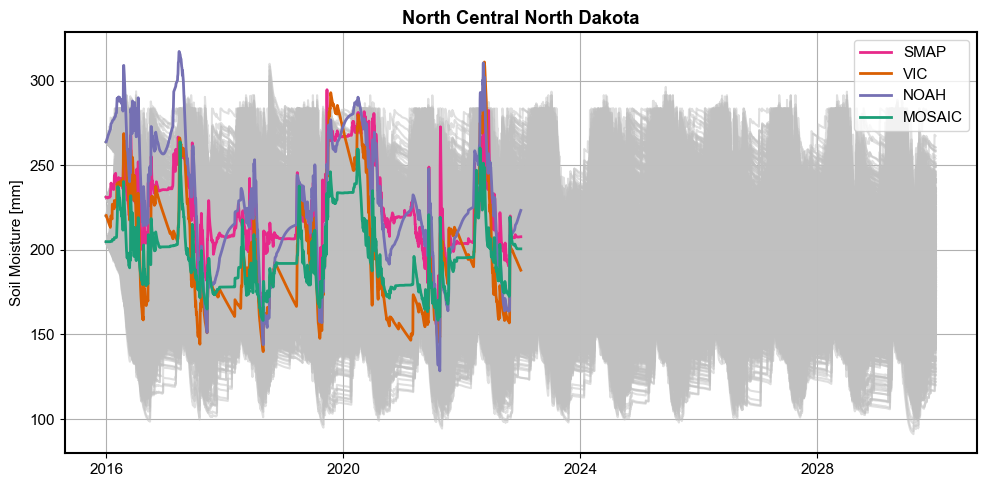

In [ ]:
# Make plot
location_name = "ncnd"
lat, lon = location_coords_dry[location_name]

fig, ax = plt.subplots(figsize=(10, 5))

# Sims
ds_all.sel(location=location_name)["soilMoist"].plot(
    hue="projection_soil_id", color="silver", alpha=0.5, label=None, ax=ax
)

# Obs
for obs_name in obs_names:
    ds_obs.sel(obs=obs_name).sel(lat=lat, lon=lon, method="nearest")[
        "soilMoist"
    ].plot(ax=ax, label=obs_name, color=obs_colors[obs_name], lw=2)

# Tidy
ax.legend()
ax.grid()
ax.set_ylabel("Soil Moisture [mm]")
ax.set_xlabel("")
ax.set_title("North Central North Dakota", fontweight="bold")

plt.tight_layout()
plt.savefig(f"../figs/si/{location_name}_timeseries_2016-2030.png", dpi=600)

/tmp/ipykernel_4154562/3294821128.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_4154562/3294821128.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../figs/si/{location_name}_timeseries_2016-2030.png', dpi=600)
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


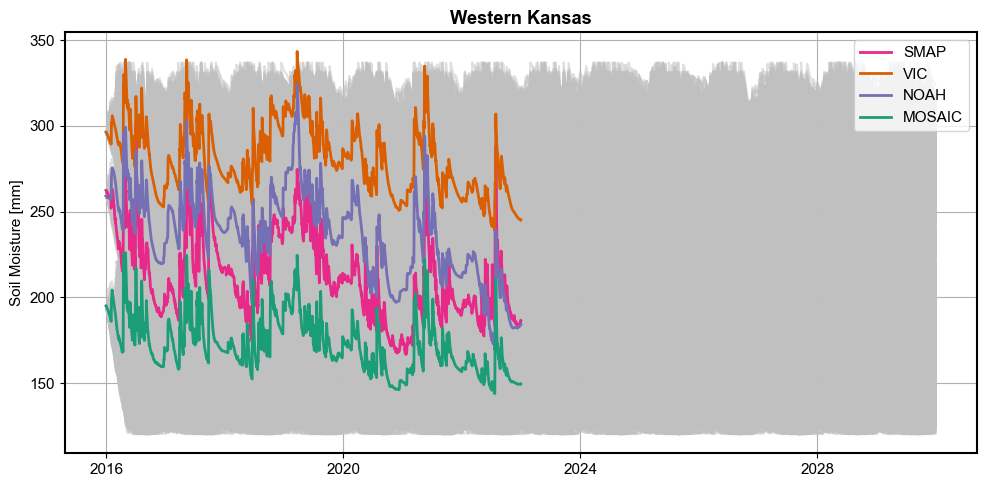

In [ ]:
# Make plot
location_name = "westkansas"
lat, lon = location_coords_dry[location_name]

fig, ax = plt.subplots(figsize=(10, 5))

# Sims
ds_all.sel(location=location_name)["soilMoist"].plot(
    hue="projection_soil_id", color="silver", alpha=0.5, label=None, ax=ax
)

# Obs
for obs_name in obs_names:
    ds_obs.sel(obs=obs_name).sel(lat=lat, lon=lon, method="nearest")[
        "soilMoist"
    ].plot(ax=ax, label=obs_name, color=obs_colors[obs_name], lw=2)

# Tidy
ax.legend()
ax.grid()
ax.set_ylabel("Soil Moisture [mm]")
ax.set_xlabel("")
ax.set_title("Western Kansas", fontweight="bold")

plt.tight_layout()
plt.savefig(f"../figs/si/{location_name}_timeseries_2016-2030.png", dpi=600)

/tmp/ipykernel_3815098/2925224733.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3815098/2925224733.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../figs/si/{location_name}_timeseries_2016-2030.png', dpi=600)
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


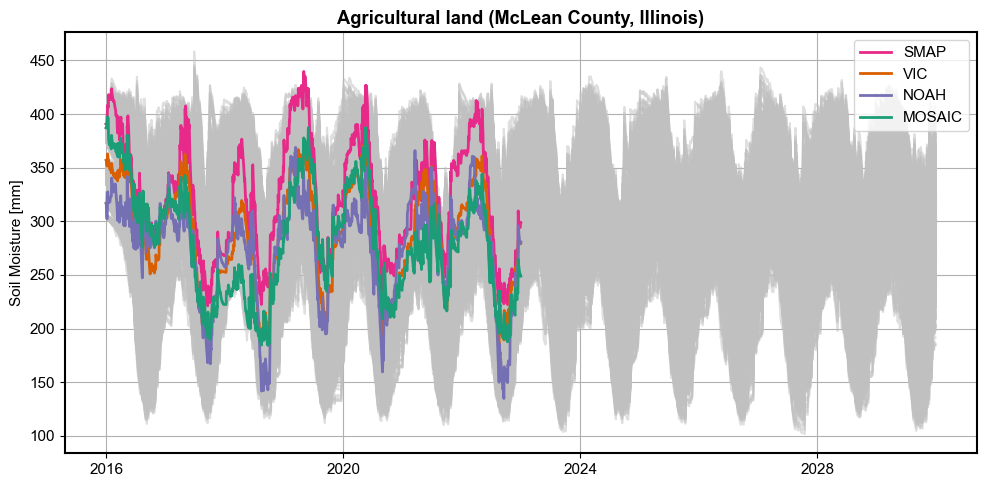

In [ ]:
# Make plot
location_name = "mclean"
lat, lon = location_coords[location_name]

fig, ax = plt.subplots(figsize=(10, 5))

# Sims
ds_all.sel(location=location_name)["soilMoist"].plot(
    hue="projection_soil_id", color="silver", alpha=0.5, label=None, ax=ax
)

# Obs
for obs_name in obs_names:
    ds_obs.sel(obs=obs_name).sel(lat=lat, lon=lon, method="nearest")[
        "soilMoist"
    ].plot(ax=ax, label=obs_name, color=obs_colors[obs_name], lw=2)

# Tidy
ax.legend()
ax.grid()
ax.set_ylabel("Soil Moisture [mm]")
ax.set_xlabel("")
ax.set_title(location_names[location_name], fontweight="bold")

plt.tight_layout()
plt.savefig(f"../figs/si/{location_name}_timeseries_2016-2030.png", dpi=600)

/tmp/ipykernel_3815098/1401903335.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3815098/1401903335.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../figs/si/{location_name}_timeseries_2016-2030.png', dpi=600)


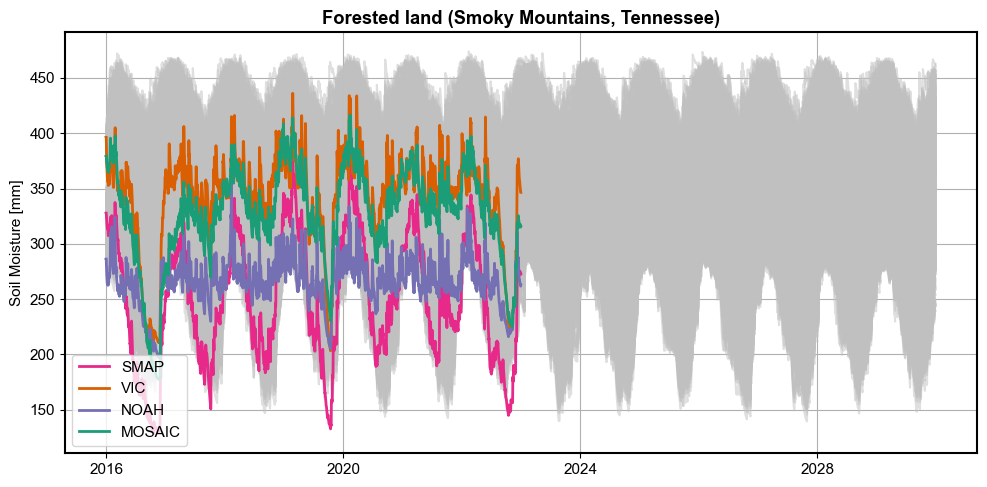

In [ ]:
# Make plot
location_name = "smoky"
lat, lon = location_coords[location_name]

fig, ax = plt.subplots(figsize=(10, 5))

# Sims
ds_all.sel(location=location_name)["soilMoist"].plot(
    hue="projection_soil_id", color="silver", alpha=0.5, label=None, ax=ax
)

# Obs
for obs_name in obs_names:
    ds_obs.sel(obs=obs_name).sel(lat=lat, lon=lon, method="nearest")[
        "soilMoist"
    ].plot(ax=ax, label=obs_name, color=obs_colors[obs_name], lw=2)

# Tidy
ax.legend()
ax.grid()
ax.set_ylabel("Soil Moisture [mm]")
ax.set_xlabel("")
ax.set_title(location_names[location_name], fontweight="bold")

plt.tight_layout()
plt.savefig(f"../figs/si/{location_name}_timeseries_2016-2030.png", dpi=600)

/tmp/ipykernel_3815098/3281767410.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3815098/3281767410.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../figs/si/{location_name}_timeseries_2016-2030.png', dpi=600)


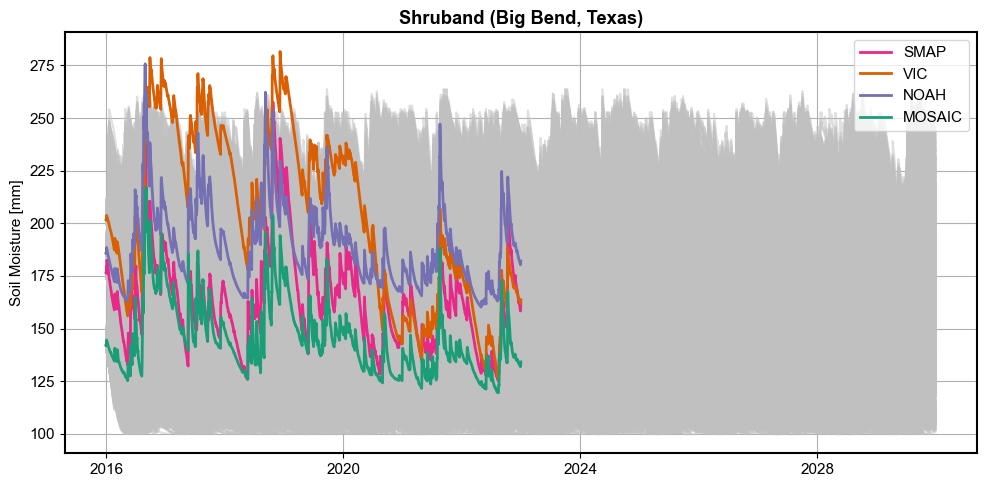

In [ ]:
# Make plot
location_name = "bigbend"
lat, lon = location_coords[location_name]

fig, ax = plt.subplots(figsize=(10, 5))

# Sims
ds_all.sel(location=location_name)["soilMoist"].plot(
    hue="projection_soil_id", color="silver", alpha=0.5, label=None, ax=ax
)

# Obs
for obs_name in obs_names:
    ds_obs.sel(obs=obs_name).sel(lat=lat, lon=lon, method="nearest")[
        "soilMoist"
    ].plot(ax=ax, label=obs_name, color=obs_colors[obs_name], lw=2)

# Tidy
ax.legend()
ax.grid()
ax.set_ylabel("Soil Moisture [mm]")
ax.set_xlabel("")
ax.set_title(location_names[location_name], fontweight="bold")

plt.tight_layout()
plt.savefig(f"../figs/si/{location_name}_timeseries_2016-2030.png", dpi=600)